# Изучение воронки продаж и результатов эксперимента по смене шрифтов в приложении продуктов питания

Исследование на данных стартапа по продаже продуктов питания в приложении.

**Цель исследования** <br> 
Необходимо оценить целесообразность замены шрифтов во всем приложении.

**Данные** <br>
В нашем распоряжении логи пользователей с 2019-07-25 по 2019-08-07, а также разделение пользователей на три группы для последующего проведения экспериментов: две контрольные со старыми шрифтами и одну экспериментальную — с новыми.

**Ход исследования** <br>
Необходимо разобраться, как ведут себя пользователи мобильного приложения. 
Для этого:
- подготовим данные, 
- оценим их качество, 
- изучим воронку продаж, 
- дадим рекомендации по проблемным местам воронки, 
- проверим гипотезы о том, как замена шрифтов в приложении повлияет на поведение пользователей и конверсию.

Приступим к предобработке данных.


### Изучение общей информации и подготовка данных

Загрузим библиотеки и датафрейм, посмотрим на первые строки, изучим общую информацию.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import stats as st
import numpy as np
import math as mth
from scipy.stats import norm
import datetime
import plotly.express as px
from plotly import graph_objects as go
from IPython.display import Image

In [2]:
logs = pd.read_csv(r'logs_exp.csv', delimiter='\t')
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Выведем необходимую первичную информацию, проверим явные дубликаты и удалим их, приведем названия столбцов к общепринятому виду. 

In [3]:
print(f'Информация по таблице logs:')
print('*'*50)
print(f'Количество явных дубликатов в первичной таблице logs: {logs.duplicated().sum()}')
logs = logs.drop_duplicates().reset_index(drop=True)
print('Все явные дубликаты удалены.')
print('*'*50)
logs.info()
logs = logs.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'device_id', 'EventTimestamp': 'event_time', 'ExpId': 'exp_id'})
logs.head()

Информация по таблице logs:
**************************************************
Количество явных дубликатов в первичной таблице logs: 413
Все явные дубликаты удалены.
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       243713 non-null  object
 1   DeviceIDHash    243713 non-null  int64 
 2   EventTimestamp  243713 non-null  int64 
 3   ExpId           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB


,event_name,device_id,event_time,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


В таблице 4 столбца и 243 713 строк. Пропусков нет.

Столбца event_time имеет неудобный формат (количество секунд, прошедших с 1 января 1970 года), приведем к типа datetime, а также добавим стобец event_date только с датой сразу после столбца с полной датой.

In [4]:
logs['event_time'] = logs['event_time'].apply(lambda x: datetime.datetime.fromtimestamp(x))
logs['event_date'] = logs['event_time'].dt.date
logs['event_date'] = pd.to_datetime(logs['event_date'])
logs = logs.reindex(columns=['event_name', 'device_id', 'event_time', 'event_date', 'exp_id'])

In [5]:
logs.head()

,event_name,device_id,event_time,event_date,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 07:43:36,2019-07-25,246
1,MainScreenAppear,7416695313311560658,2019-07-25 14:11:42,2019-07-25,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 14:28:47,2019-07-25,248
3,CartScreenAppear,3518123091307005509,2019-07-25 14:28:47,2019-07-25,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 14:48:42,2019-07-25,248


Структура таблицы:

- `event_name` — название события,
- `device_id` — уникальный идентификатор пользователя,
- `event_time` —  дата и время события,
- `event_date` —  дата события,
- `exp_id` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Предобработка данных окончена: таблица имеет читабельный вид и нужные для дальнейшего анализа столбцы в нужных форматах, явные дубликаты удалены. Переходим к изучению самих данных.

### Анализ временных данных

Посмотрим, данными за какой период мы располагаем.

In [6]:
d1 = logs['event_date'].min()
d2 = logs['event_date'].max()
print(f'Данные собраны за период с {d1} по {d2}.')

Данные собраны за период с 2019-07-25 00:00:00 по 2019-08-08 00:00:00.


Изучим, как меняется количество данных в зависимости от времени.

In [7]:
logs['event_date'].value_counts().sort_index(ascending=True)

2019-07-25        9
2019-07-26       30
2019-07-27       55
2019-07-28      104
2019-07-29      181
2019-07-30      397
2019-07-31     1213
2019-08-01    35767
2019-08-02    35571
2019-08-03    33602
2019-08-04    32583
2019-08-05    36075
2019-08-06    36270
2019-08-07    31788
2019-08-08       68
Name: event_date, dtype: int64

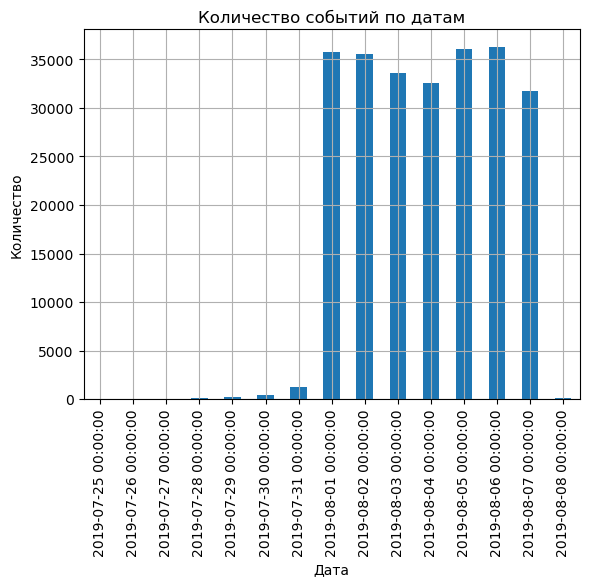

In [8]:
logs['event_date'].value_counts().sort_index(ascending=True).plot(kind='bar')
plt.title('Количество событий по датам')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.grid()
plt.show()

Судя по тому, что начиная с 1 августа держится примерно одинаковое количество событий, а в период до 1 августа событий несравнимо меньше, можно сделать вывод, что данные до 1 августа неполные. 

Посмотрим на данные не только по дате, но и по времени:

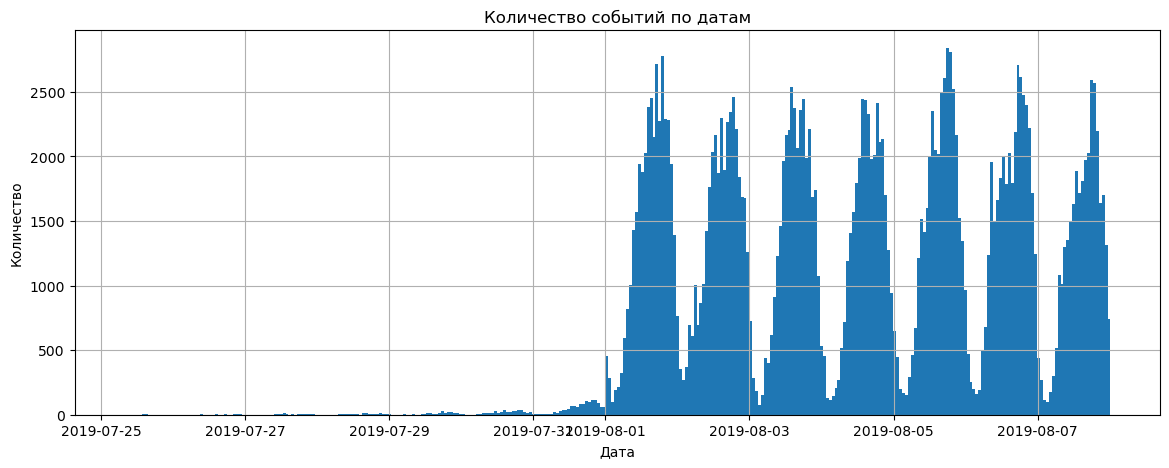

In [9]:
logs['event_time'].hist(bins=336, figsize=(14, 5))
plt.grid(True)
plt.title('Количество событий по датам')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.show()

Видим, что в ночные часы активности не много, в основном все события происходят днем.

Посмотрим на данные переходного периода - 31 июля и 1 августа.

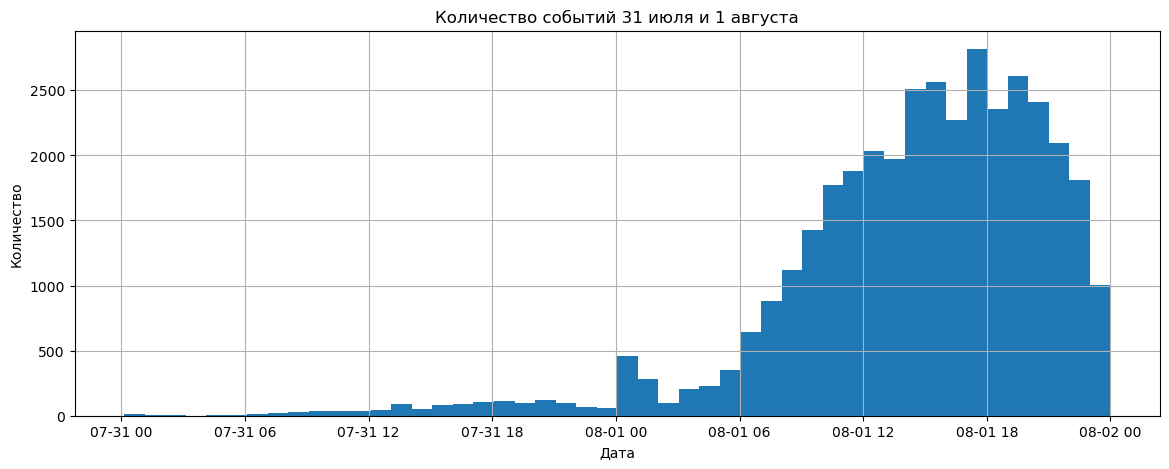

In [10]:
logs[(logs['event_time'] > '2019.07.31 00:00:00') & (logs['event_time'] < '2019.08.02 00:00:00')]['event_time'].hist(bins=48, figsize=(14, 5))
plt.grid(True)
plt.title('Количество событий 31 июля и 1 августа')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.show()

Видим, что тест был запущен в районе 21 часа 31 июля. В это время начинается всплеск на графике, далее он ведет себя равномерно по датам и времени.

Посчитаем сколько всего событий в нашем логе и количество уникальных пользователей до удаления данных.

In [11]:
shape1 = logs.shape[0]
print(f'Количество событий в логе: {shape1}')

Количество событий в логе: 243713


In [12]:
unique1 = logs['event_name'].nunique()
print(f'Количество уникальных событий в логе: {unique1}')

Количество уникальных событий в логе: 5


In [13]:
unique_users1 = logs['device_id'].nunique()
print(f'Количество уникальных пользователей в логе: {unique_users1}')

Количество уникальных пользователей в логе: 7551


Чтобы понять, сколько уникальных событий приходится на пользователя, создадим таблицу с количеством событий каждого юзера и посмотрим на их распределение.

In [14]:
events_by_users = (
    logs
    .groupby('device_id')
    .agg({'event_name': 'count'})
    .rename(columns={'event_name':'number_of_events'})
    .reset_index()
)
events_by_users.head()

,device_id,number_of_events
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47
3,7435777799948366,6
4,7702139951469979,137


In [15]:
events_by_users['number_of_events'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: number_of_events, dtype: float64

Таким образом, на грязных данных на одного пользователя приходится в среднем 32 события, медиана - 20 событий на человека.

Построим диаграмму рассеивания, чтобы посмотреть на выбросы.

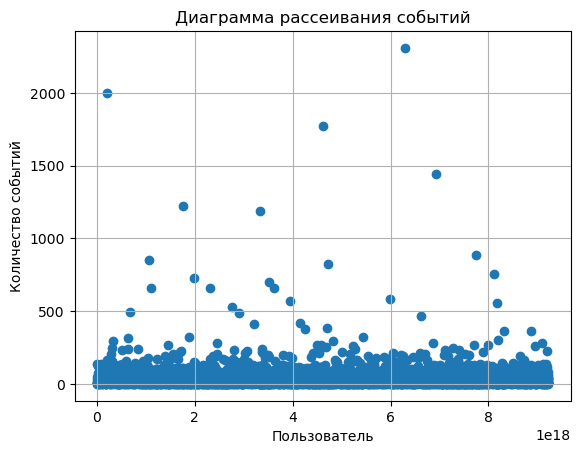

In [16]:
plt.scatter(events_by_users['device_id'], events_by_users['number_of_events'])
plt.grid(True)
plt.title('Диаграмма рассеивания событий')
plt.xlabel('Пользователь')
plt.ylabel('Количество событий')
plt.show()

Видим небольшое количество выбросов. Посчитам 95 и 99 перцентиль.

In [17]:
np.percentile(events_by_users['number_of_events'], [95, 99])

array([ 89. , 200.5])

До 5% покупателей оформляли больше, чем 89 заказов. И только 1% пользователей оформлял заказ более 200 раз. 
Отбросим всех пользователей, которые сделали более 200 заказов.

In [18]:
list_of_strange_users = events_by_users.loc[events_by_users['number_of_events'] > 200, 'device_id'].tolist()

Удалим из нашей таблицы logs всех юзеров из листа list_of_strange_users.

In [19]:
logs = logs[~logs['device_id'].isin(list_of_strange_users)]

Также отбросим все данные до 1 августа, так как они могут исказить картину.

In [20]:
logs = logs[logs['event_date'] > '2019-07-31']

In [21]:
d1 = logs['event_date'].min()
d2 = logs['event_date'].max()
print(f'Данные собраны за период с {d1} по {d2}.')

Данные собраны за период с 2019-08-01 00:00:00 по 2019-08-08 00:00:00.


Проверим, как изменилось количество событий, пользователей, и среднее количество событий на пользователя после удаления.

In [22]:
shape2 = logs.shape[0]
print(f'В логе стало на {100-shape2/shape1*100:.2f}% меньше событий.')

В логе стало на 14.91% меньше событий.


In [23]:
unique2 = logs['event_name'].nunique()
print(f'Количество уникальных событий в логе: {unique1}')

if unique2 == unique1:
    print('Количество уникальных событий не изменилось.')

Количество уникальных событий в логе: 5
Количество уникальных событий не изменилось.


In [24]:
unique_users2 = logs['device_id'].nunique()
print(f'В логе стало на {100-unique_users2/unique_users1*100:.1f}% меньше уникальных пользователей.')

В логе стало на 1.2% меньше уникальных пользователей.


In [25]:
events_by_users2 = (
    logs
    .groupby('device_id')
    .agg({'event_name': 'count'})
    .rename(columns={'event_name':'number_of_events'})
    .reset_index()
)
events_by_users2['number_of_events'].describe()

count    7462.000000
mean       27.789601
std        27.727438
min         1.000000
25%         9.000000
50%        19.000000
75%        36.000000
max       199.000000
Name: number_of_events, dtype: float64

Таким образом, на очищенных данных на одного пользователя приходится в среднем 28 событий, медиана - 19 событий на человека.

Провели очистку данных. Теперь проверим, есть ли в данных пользователи из всех трёх экспериментальных групп.

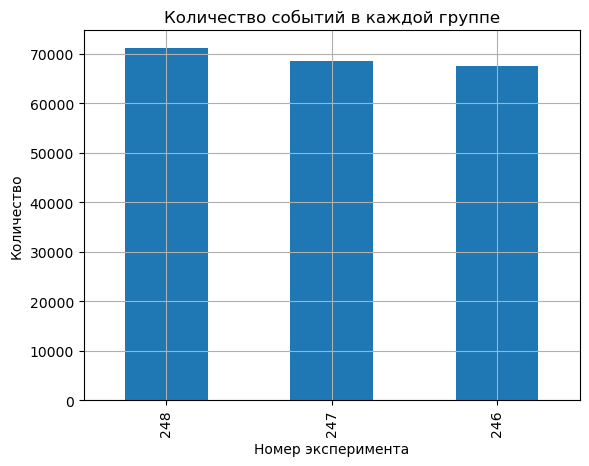

In [26]:
logs['exp_id'].value_counts().plot(kind='bar')
plt.title('Количество событий в каждой группе')
plt.xlabel('Номер эксперимента')
plt.ylabel('Количество')
plt.grid()
plt.show()

В каждой группе примерно одинаковое количество событий. Переходим к анализу воронки продаж.

### Анализ воронки продаж

Посмотрим на воронку продаж в разрезе всех событий и в разрезе уникальных пользователей. Сначала посмотрим на все события лога.

In [27]:
counts = logs['event_name'].value_counts()
counts

MainScreenAppear           113801
OffersScreenAppear          41113
CartScreenAppear            29279
PaymentScreenSuccessful     22187
Tutorial                      986
Name: event_name, dtype: int64

Видим 5 последовательных событий воронки продаж:
    
- `MainScreenAppear` — главный экран,
- `OffersScreenAppear` — предложения,
- `CartScreenAppear` —  корзина,
- `PaymentScreenSuccessful` —  успешная оплата,
- `Tutorial` — инструкция.

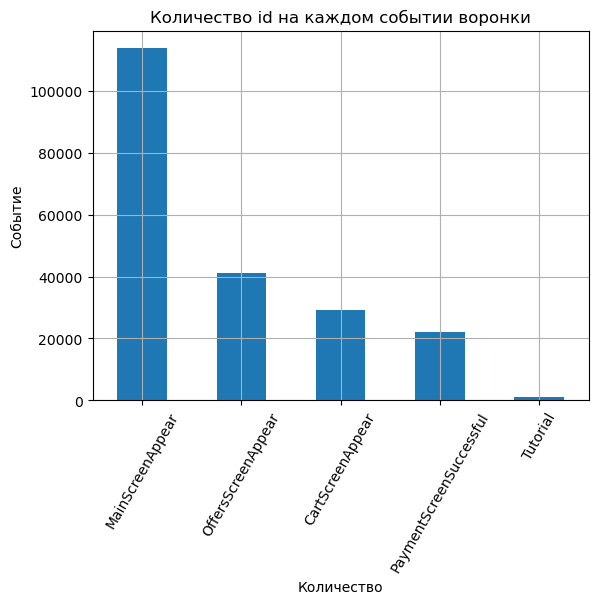

In [28]:
logs['event_name'].value_counts().plot(kind='bar')
plt.title('Количество id на каждом событии воронки')
plt.xlabel('Количество')
plt.ylabel('Событие')
plt.xticks(rotation=60)
plt.grid()
plt.show()

In [29]:
counts_pers = counts/counts.shift(1)*100
counts_pers.round(2)

MainScreenAppear             NaN
OffersScreenAppear         36.13
CartScreenAppear           71.22
PaymentScreenSuccessful    75.78
Tutorial                    4.44
Name: event_name, dtype: float64

Из 113 тыс показов главного экрана только 36% (примерно 40 тыс) дошли до просмотра предложений, далее 71% (29 тыс) перешел на следующий этап (просмотр корзины), 75% (22 тыс) оформили покупку, и далее всего 4,5% из них (980 человек) дошли до чтения инструкций.

Построим график распределения событий по дням.

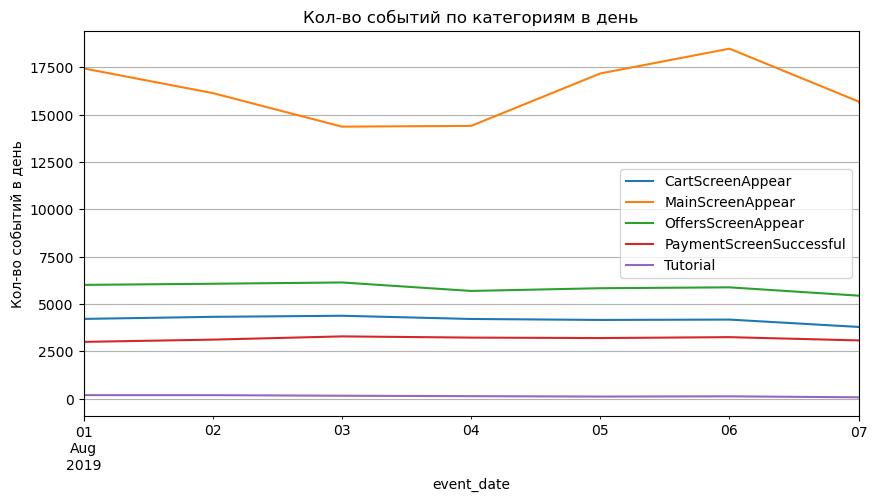

In [30]:
events = logs.pivot_table(index='event_date', columns='event_name', values='device_id', aggfunc=('count'))
events.plot(kind='line', figsize=(10, 5))
ax = plt.gca()
ax.set_xlim([18109, 18115]) #формат количества дней с 1 января 1970 года
plt.ylabel('День эксперимента')
plt.ylabel('Кол-во событий в день')
plt.title('Кол-во событий по категориям в день')
plt.legend(loc='center right')
plt.grid()
plt.show()

Видим, что на главную страницу пользователи заходили неравномерно: 3 , 4 и 7 августа было меньше посещений. Это может быть связанно с днями недели, праздниками, с техническими проблемами в приложении, либо с нашими рекламными кампаниями, которые могли повысить посещаемость в другие дни.

Остальные события распределены по дням равномерно.

Проведем расчеты и построение воронки продаж по уникальным пользователям. Для этого создадим сводную таблицу.

In [31]:
pivot_users = logs.pivot_table(index = 'device_id', columns = 'event_name', values = 'event_date', aggfunc='first').count()
pivot = pivot_users.sort_values(ascending = False)
pivot

event_name
MainScreenAppear           7348
OffersScreenAppear         4521
CartScreenAppear           3660
PaymentScreenSuccessful    3464
Tutorial                    827
dtype: int64

In [32]:
counts_pers_un = pivot/pivot.shift(1)*100
counts_pers_un.round(2)

event_name
MainScreenAppear             NaN
OffersScreenAppear         61.53
CartScreenAppear           80.96
PaymentScreenSuccessful    94.64
Tutorial                   23.87
dtype: float64

Итак, мы видим, что значительная часть потенциальных покупателей (почти 40%) не переходят с главной страницы на страницу с предложениями. Рекомендации для маркетологов настроить вид этой страницы так, чтобы возможность перехода на страницы с предложениями стала заметнее для пользователе. Чтобы пользователи видели этот переход (кнопку, ссылку) и хотели его произвести.

Среди тех, кто увидел предложения, 80% что-то положили в корзину, это хороший показатель. Очевидно, нам есть что предложить покупателям, и у них есть желание это приобрести.

На этапе оплаты исчезает 6% пользователей. Соотественно, мы можем попробовать напомнить им о том, что в корзине есть товары.

Инструкции же мало кто читает. Если это важная составляющая нашего бизнеса, то необходимо понять, что происходит на этом этапе и почему люди не хотят (или не могут) ее прочитать.

Чтение туториала не является часть воронки, поэтому построим график воронки без него.

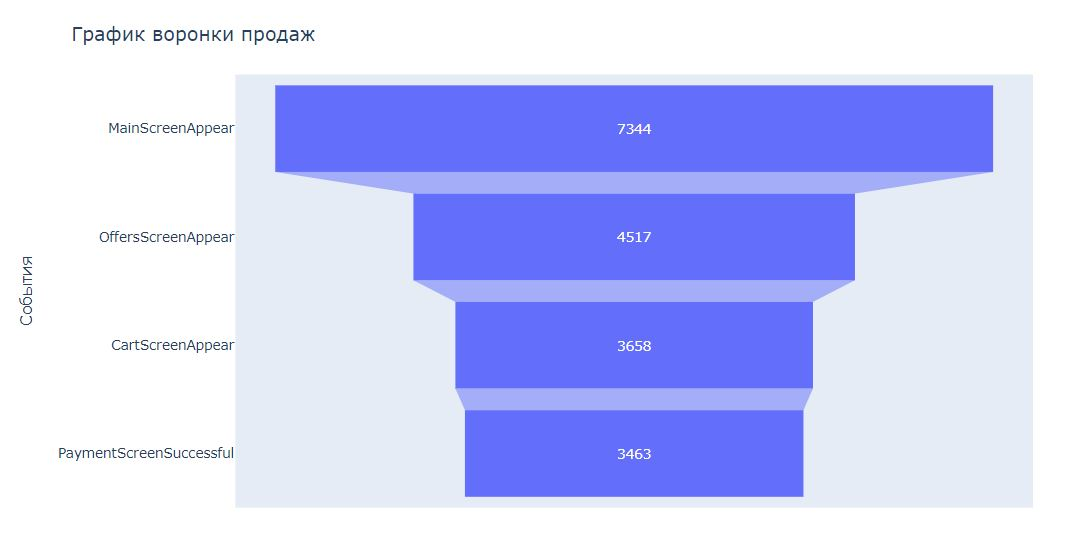

In [33]:
data1 = dict(
    number=pivot[0:4],
    События=["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"])
fig = px.funnel(data1, x='number', y='События')
fig.update_layout(title="График воронки продаж")

Image("воронка.jpg")

Также посчитаем конверсию из посетителя в покупателя.

In [34]:
number_of_unique_success = logs[logs['event_name'] == 'PaymentScreenSuccessful']['device_id'].nunique()
number_of_unique_success

3464

In [35]:
success = number_of_unique_success / unique_users2
print(f'Конверсия из просмотра страницы в покупку по уникальным пользователям составляет {success*100:.2f}%')

Конверсия из просмотра страницы в покупку по уникальным пользователям составляет 46.42%


### Изучение результатов A/A/B-эксперимента

Был проведен эксперимент по замене шрифтов во всем приложении. Пользователей поделили на три группы: 248 — экспериментальная группа, 246 и 247 — контрольные.


Как мы выяснили ранее, в каждой из наших трех групп попало примерно одинаковое количество событий:

In [36]:
logs['exp_id'].value_counts()

248    71188
247    68545
246    67633
Name: exp_id, dtype: int64

Посмотрим, сколько уникальных пользователей попало в каждую группу.

In [37]:
logs.groupby('exp_id')['device_id'].nunique()

exp_id
246    2456
247    2495
248    2511
Name: device_id, dtype: int64

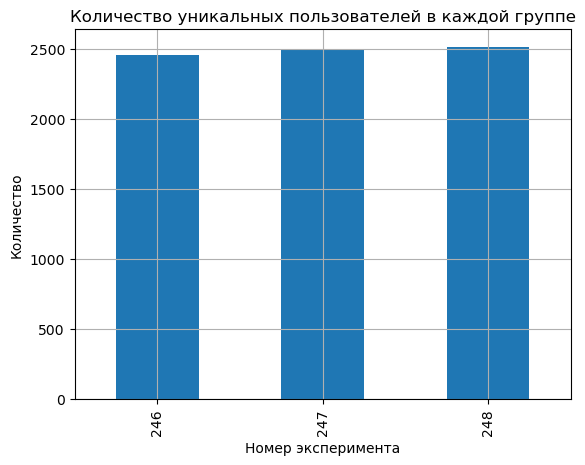

In [38]:
logs.groupby('exp_id')['device_id'].nunique().plot(kind='bar')
plt.title('Количество уникальных пользователей в каждой группе')
plt.xlabel('Номер эксперимента')
plt.ylabel('Количество')
plt.grid()
plt.show()

Уникальные пользователи распределились тоже равномерно.

Проверим, есть ли пользователи, попавших сразу в несколько экспериментальных групп.

In [39]:
logs.groupby(['device_id']).agg({'exp_id': 'nunique'}).sort_values(by = 'exp_id', ascending = False).head()

,exp_id
device_id,
6888746892508752,1
6208308869477863893,1
6221557117339142225,1
6217807653094995999,1
6217295124800833842,1


Пользователи были распределены равномерно, попавших в несколько экспериментальных групп - нет.

Далее мы проведем несколько двусторонних тестов для определения статистической значимости  различий в 2-х группах.

Назначим уровень статистический значимости 0.05.  Таким образом вероятность ошибки первого рода (отклонение верной нулевой гипотезы) будет составлять 5%. Будет проводиться двусторонний тест.

Создадим функцию:

In [40]:
def stat_func(successes, trials):
    alpha = 0.05
    p1 = successes[0] / trials[0] # пропорция успехов в первой группе
    p2 = successes[1] / trials[1] # пропорция успехов во второй группе
    print(successes[0], successes[1], trials[0], trials[1])
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1]) # пропорцию успехов в комбинированном датасете
    difference = p1 - p2 # разница пропорций в датасетах
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])) # считаем статистику в ст.отклонениях стандартного нормального распределения
    distr = st.norm(0, 1)  # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print('p-значение: ', p_value.round(2))
    return p_value

Переходим к проверке гипотез.

Сформулируем их:

H0 - две генеральные совокупности равны, 
H1 (альтернативная гипотеза) - между генеральными совокупностями есть отличие.

#### Проверка результатов А/A-эксперимента (246, 247 - контрольные группы)

У нас есть две контрольные группы для А/А-эксперимента. Проверим, находят ли статистические критерии разницу между выборками 246 и 247 для проверить корректности всех механизмов и расчётов.

Делаем срез данных по контрольным группам и проверяем количество уникальных пользователей, совершивших действие, в каждой группе.

In [41]:
groups = [246, 247] 
data_for_aa = logs.query('exp_id in @groups') 
data_for_aa_pivot = data_for_aa.pivot_table(index = 'event_name', columns = 'exp_id', values = 'device_id', aggfunc=('nunique'))
display(data_for_aa_pivot)

exp_id,246,247
event_name,,
CartScreenAppear,1238,1217
MainScreenAppear,2423,2457
OffersScreenAppear,1514,1502
PaymentScreenSuccessful,1172,1136
Tutorial,269,280


Создаем цикл для подачи аргументов в функцию и проверяем результаты:

In [42]:
for event_name in data_for_aa_pivot.index:
    trials = np.array([2484, 2513])
    success = list([data_for_aa_pivot.loc[event_name, 246], data_for_aa_pivot.loc[event_name, 247]])
    stat_func(success, trials)

1238 1217 2484 2513
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.32
2423 2457 2484 2513
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6
1514 1502 2484 2513
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.39
1172 1136 2484 2513
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.16
269 280 2484 2513
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.72


Тест не показал статистических различий между двумя выборками-контрольными группами генеральной совокупности. 

#### Проверка результатов А/В-эксперимента (246 - контрольная, 248 - тестовая)

Делаем срез данных по контрольным группам и проверяем количество уникальных пользователей, совершивших действие, в каждой группе.

In [43]:
groups = [246, 248] 
data_for_ab1 = logs.query('exp_id in @groups') 
data_for_ab1_pivot = data_for_ab1.pivot_table(index = 'event_name', columns = 'exp_id', values = 'device_id', aggfunc=('nunique'))
display(data_for_ab1_pivot)

exp_id,246,248
event_name,,
CartScreenAppear,1238,1205
MainScreenAppear,2423,2468
OffersScreenAppear,1514,1505
PaymentScreenSuccessful,1172,1156
Tutorial,269,278


Создаем цикл для подачи аргументов в функцию и проверяем результаты:

In [44]:
for event_name in data_for_ab1_pivot.index:
    trials = np.array([2484, 2537])
    success = list([data_for_ab1_pivot.loc[event_name, 246], data_for_ab1_pivot.loc[event_name, 248]])
    stat_func(success, trials)

1238 1205 2484 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.1
2423 2468 2484 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.56
1514 1505 2484 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.24
1172 1156 2484 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.25
269 278 2484 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.88


Тест не показал статистических различий между двумя выборками (контрольной и экспериментальной группами) генеральной совокупности.

#### Проверка результатов А/В-эксперимента (247 - контрольная, 248 - тестовая)

Делаем срез данных по контрольным группам и проверяем количество уникальных пользователей, совершивших действие, в каждой группе.

In [45]:
groups = [247, 248] 
data_for_ab2 = logs.query('exp_id in @groups') 
data_for_ab2_pivot = data_for_ab2.pivot_table(index = 'event_name', columns = 'exp_id', values = 'device_id', aggfunc=('nunique'))
display(data_for_ab2_pivot)

exp_id,247,248
event_name,,
CartScreenAppear,1217,1205
MainScreenAppear,2457,2468
OffersScreenAppear,1502,1505
PaymentScreenSuccessful,1136,1156
Tutorial,280,278


Создаем цикл для подачи аргументов в функцию и проверяем результаты:

In [46]:
for event_name in data_for_ab2_pivot.index:
    trials = np.array([2513, 2537])
    success = list([data_for_ab2_pivot.loc[event_name, 247], data_for_ab2_pivot.loc[event_name, 248]])
    stat_func(success, trials)

1217 1205 2513 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.51
2457 2468 2513 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.26
1502 1505 2513 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.75
1136 1156 2513 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.8
280 278 2513 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.83


Тест не показал статистических различий между двумя выборками (контрольной и экспериментальной группами) генеральной совокупности.

#### Проверка результатов (А+A)/В-эксперимента (246+247 - контрольная, 248 - тестовая)

Делаем срез данных по контрольным группам и проверяем количество уникальных пользователей, совершивших действие, в каждой группе. Просуммируем результаты двух контрольных групп.

In [47]:
data_for_aab_pivot = logs.pivot_table(index = 'event_name', columns = 'exp_id', values = 'device_id', aggfunc=('nunique'))

data_for_aab_pivot['A+A'] = data_for_aab_pivot[246] + data_for_aab_pivot[247]

display(data_for_aab_pivot[['A+A', 248]])

exp_id,A+A,248
event_name,,
CartScreenAppear,2455,1205
MainScreenAppear,4880,2468
OffersScreenAppear,3016,1505
PaymentScreenSuccessful,2308,1156
Tutorial,549,278


Создаем цикл для подачи аргументов в функцию и проверяем результаты:

In [48]:
for event_name in data_for_aab_pivot.index:
    trials = np.array([4997, 2537])
    success = list([data_for_aab_pivot.loc[event_name, 'A+A'], data_for_aab_pivot.loc[event_name, 248]])
    stat_func(success, trials)

2455 1205 4997 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.18
4880 2468 4997 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.32
3016 1505 4997 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.39
2308 1156 4997 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.61
549 278 4997 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.97


Тест не показал статистических различий между двумя выборками (суммарной контрольной и экспериментальной группами) генеральной совокупности.

#### Поправка Бонферрони 

Вероятность получения ложного срабатывания возрастает при проведении нескольких проверок гипотез. Мы провели сразу четыре проверки, поэтому можно воспользоваться поправкой Бонферрони. 

Уровень статистической значимости с учетом поправки:

In [49]:
print(f'Новый уровень стат. значимости с учетом поправки: {0.05/4}')

Новый уровень стат. значимости с учетом поправки: 0.0125


При проведении теста с учетом поправки результаты не изменились. Оставляем общепринятый уровень 0.05.

#### Выводы по результатам проведения тестов

По результатам всех четырех проведенных тестов различий между выборками не обнаружено.  Мы можем остановить проведение теста и сделать выводы, что изменение шрифтов не оказывает влияния на поведение пользователей и не влияет на конверсию.

Мы использовали уровень статистической значимости 0,05 (общепринятый стандартный уровень), но также провели тесты с учетом поправки Бонферрони с уровнем стат. значимости 0.0125. Результаты не отличаются. 

### Выводы

Было проведено исследование на данных логов приложения по продаже продуктов питания. 

На первом этапе мы провели предобработку данных, удалили дубликаты, поменяли типы данных, добавили необходимые для дальнейшего анализа столбцы. Итоговая таблица имеет 5 столбцов: название события, id пользователя, дата события со временем, дата события и номер эксперимента (246 и 247 — контрольные группы, а 248 — экспериментальная). 

Также мы увидели, что не все данные в логах адекватны и полны и отбросили неполную часть. В результате мы оставили данные за неделю с 1 по 7 августа 2019 года. Также были отброшены пользователи, находящиеся в 99-перцентиле по количеству заказов (паталогически высокое количество заказов за период).

Далее мы изучили воронку продаж. Полный цикл действий пользователя выглядит так: главный экран - чтение предложений - корзина - успешная оплата - чтение инструкций. С главного экрана до предложений не доходить примерно 40% пользователей, на следующем этапе (корзина) мы теряем еще 20% пользователей, далее 94% из них оформляют покупку, и всего 24% доходят до чтения инструкций.

Конверсию из посетителя в покупателя составляет 46%.

В рекомендация для отдела маркетинга: сделать заметнее кнопку с предложениями и активнее стимулировать людей переходить в них. Также стоит напоминать о лежащих в корзинах продуктах. Для технической поддержки запрос разобраться, почему всего 24% доходит до инструкций, вероятно, существует какая-то техническая проблема.

Далее мы переходим к проверке статистических гипотез. Нам нужно понять, стоит ли вкладывать деньги в замену шрифтов во всем приложении. Мы провели 4 статистических теста: тест для оценки двух контрольных групп, два теста для сравнения контролных и экспериментальной группы и тест для суммарной контрольной группы с экспериментальной.

Провели эти тесты с двумя уровнями статистической значимости: общепринятой 0.05 и с поправкой Бонферрони 0.0125.

Ни один из проведенных тестов не смог отвергнуть нулевую гипотезу, которая гласила, что две генеральные совокупности равны.

Таким образом, мы сделали вывод, что замена шрифтов не влияет на поведение пользователей и финансирование в эту идею не имеет смысла.